First implementation of a trajectory transformer, where each observation is a vector of [lat lon, sog, cog]

In [46]:

from collections import defaultdict
from typing import Iterator, List

import numpy as np 
import torch
import torch.nn as nn
import torch.functional as f
import torch.nn.functional as F
import pickle 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler
from tqdm.notebook import tqdm as tnb
from tqdm import tqdm

torch.set_default_dtype(torch.float64)
device = torch.device('cuda:0')

In [196]:
# Parameters (could move to config file if wanna be fancy)

train_path = './Data/OG Data/marinedata_train.pkl'
val_path = './Data/OG Data/marinedata_val.pkl'

d_model = 128 # Size of the embedding space
max_seq_time = 144 # Maximum number of observations per trajectory
min_seq_time = 24
input_dim = 4 # [lat, lon, sog, cog]
output_dim = input_dim # [lat, lon, sog, cog]
n_enc_layers = 6 
n_dec_layers = n_enc_layers
n_heads = 8 # number of attentionheads in the encoder and decoder
d_ff = 512 # Dimension of the ff nn at the end of a block

batch_by_size = True
batch_size = 64

params = [input_dim, d_model, n_heads, n_enc_layers, n_dec_layers, d_ff, max_seq_time, output_dim]

In [197]:
class PositionalEncoding(nn.Module):
    """
    Postional encoder using the sinusiodals from the original paper
    """
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype = torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()*(-torch.log(torch.tensor(10000.0))/d_model))
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        pe = pe.unsqueeze(0).transpose(0,1)
        self.pe = pe.to(device)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x
    

class TrajectoryEncoder(nn.Module):
    """
    Basic Encoder relying mainly on pytorchs modules 
    """
    def __init__(self, input_dim, d_model, n_heads, n_enc_layers, d_ff, max_len):
        super(TrajectoryEncoder, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        enc_layers = nn.TransformerEncoderLayer(d_model, n_heads, d_ff, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(enc_layers, n_enc_layers)

    def forward(self, src):
        x = self.input_proj(src) # Take our input from input_dim to embedding-d
        x = self.pos_enc(x)
        x = self.transformer_encoder(x)
        return x

In [198]:
class TrajectoryDecoder(nn.Module):

    def __init__(self, input_dim, d_model, n_heads, n_dec_layers, d_ff, max_len, 
                 output_dim):
        super(TrajectoryDecoder, self).__init__()
        self.emb_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        dec_layers = nn.TransformerDecoderLayer(d_model, n_heads, d_ff, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(dec_layers, n_dec_layers)
        self.output_proj = nn.Linear(d_model, output_dim)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        """
        tgt (Tensor) = the sequence to the decoder (required).

        memory (Tensor) = the sequence from the last layer of the encoder. Size bs, T, n_emb
        """
        tgt = self.emb_proj(tgt)
        target = self.pos_enc(tgt)
        decoded = self.transformer_decoder(target, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        output = self.output_proj(decoded) # project down to output_dim
        return output

In [199]:
class TrajectoryAutoencoder(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, n_enc_layers, n_dec_layers, d_ff, max_len, output_dim):
        super(TrajectoryAutoencoder, self).__init__()
        self.encoder = TrajectoryEncoder(input_dim, d_model, n_heads, n_enc_layers, d_ff, max_len)
        self.decoder = TrajectoryDecoder(input_dim, d_model, n_heads, n_dec_layers, d_ff, max_len, output_dim)

    def forward(self, tgt):
        memory = self.encoder(tgt)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(1))
        reconstructed = self.decoder(tgt, memory, tgt_mask=tgt_mask)
        return reconstructed

In [200]:
min_time = min_seq_time
if min_time>max_seq_time:
    min_time = max_seq_time

class MarineDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx]).to(device)

class MarineDatasetPadding(Dataset):
    def __init__(self, data_dictionary, min_seq_len, max_seq_len, n_features):

        self.min_seq_len = min_seq_len
        self.max_seq_len = max_seq_len
        self.n_features = n_features

        self.dict = data_dictionary
        self.keys = list(data_dictionary.keys())

        for key in self.keys:
            if len(self.dict[key]['traj']) < min_seq_len:
                del self.dict[key]
                self.keys.remove(key)


    def __len__(self):
        return len(self.dict)
    
    def __getitem__(self, idx):
        key = self.keys[idx]
        traj_data = self.dict[key]['traj']
        
        # Cut off the mmsi and timestamp and return trajectory
        if len(traj_data) >= self.max_seq_len:
            return torch.tensor(traj_data[:self.max_seq_len,:self.n_features])
        else: 
            needed_padding = self.max_seq_len - len(traj_data)
            res = F.pad(torch.tensor(traj_data[:,:self.n_features]), (0,0, 0, needed_padding), "constant", 0.0)
        
            return res.to(device)

class BatchBySizeSampler(Sampler[List[int]]):
    def __init__(self, data, batch_size):
        self.batch_size = batch_size
        paths_by_length = defaultdict(list)
        for i, path in enumerate(data):
            paths_by_length[len(path)].append(i)
        self.paths_by_length = list(paths_by_length.values())
        self.num_batches = sum((len(xs) + batch_size - 1) // batch_size for xs in self.paths_by_length)

    def __len__(self):
        return self.num_batches

    def __iter__(self) -> Iterator[List[int]]:
        for xs in self.paths_by_length:
            np.random.shuffle(xs)
        chunks = [xs[i : i + self.batch_size] for xs in self.paths_by_length for i in range(0, len(xs), self.batch_size)]
        np.random.shuffle(chunks)
        yield from chunks


def merge_path_lists(l1, l2):
    inner_1 = len(l1[0])
    inner_2 = len(l2[0])
    if inner_1 > inner_2:
        l1, l2 = l2, l1
    target_inner = len(l1[0])
    for p in l2:
        l1.append(p[:target_inner])
    return l1

def merge_lengths(all_paths):
    paths_by_length = defaultdict(list)
    for path in all_paths:
        paths_by_length[len(path)].append(path)
    paths_by_length = list(paths_by_length.values())
    paths_by_length.sort(key=len)
    fixed = []
    i = 0
    while i < len(paths_by_length):
        curr = paths_by_length[i]
        """
        maybe make each bucket strictly larger than batch size (currently equal is allowed)?
         - this would prevent batches with exact same items between epochs
         - problem is it would lead to small "excess batches", that is batches with fewer than batch_size #paths in them
         - for example, bucket of size (batch_size + 1) leads to one batch with batch_size #paths and one with a single path
                => might mess with gradient step
        """
        while len(curr) < batch_size:
            curr = merge_path_lists(curr, paths_by_length[i + 1])
            i += 1
        fixed.append(curr)
        i += 1
    return [x for xs in fixed for x in xs]


if batch_by_size:
    with open(train_path, 'rb') as f:
        train_data = pickle.load(f)
        train_data = [x["traj"][:max_seq_time,:input_dim] for x in train_data.values() if len(x["traj"]) >= min_seq_time]
    with open(val_path, 'rb') as f:
        val_data = pickle.load(f)
        val_data = [x["traj"][:max_seq_time,:input_dim] for x in val_data.values() if len(x["traj"]) >= min_seq_time]
    
    train_merged = merge_lengths(train_data)
    val_merged = merge_lengths(val_data)
    
    train_dataloader = DataLoader(MarineDataset(train_merged), batch_sampler=BatchBySizeSampler(train_merged, batch_size))
    validation_dataloader = DataLoader(MarineDataset(val_merged), batch_sampler=BatchBySizeSampler(val_merged, batch_size))
else:
    with open(train_path, 'rb') as f:
        train_data = pickle.load(f)
    with open(val_path, 'rb') as f:
        val_data = pickle.load(f)
    train_dataloader = DataLoader(MarineDatasetPadding(train_data, min_seq_len=min_seq_time, max_seq_len=max_seq_time, n_features=input_dim), batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(MarineDatasetPadding(val_data, min_seq_len=min_seq_time, max_seq_len=max_seq_time, n_features=input_dim), batch_size=batch_size, shuffle=True)

In [201]:
# Lat min 53.4 max 66.2
# lon min 9.4 max 30.5
# Max speed 50
# Max heading 360

def train_loop(model, dataloader, criterion, optimizer):
    train_data_size = len(dataloader.dataset)
    model.train()
    cum_loss = 0.0
    acc = 0
    for batch, X in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, X)
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()

        acc += len(X)
        if batch % 10 == 0:
            print(f' loss {loss.item():>4f} [{acc:>5d} / {train_data_size:>5d} ]', flush=True)
    return cum_loss

def test_loop(model, dataloader, criterion):
    model.eval()
    cum_loss = 0.0
    loss = []
    with torch.no_grad():
        for X in dataloader:
            pred = model(X)
            current_loss = criterion(X, pred).item()
            cum_loss += current_loss

            loss.append(current_loss)

    print(f'Test set: \nCumulative loss: {cum_loss}, Average Loss {np.mean(loss):>8f}')
    return cum_loss

In [202]:
model = TrajectoryAutoencoder(*params)
model = model.to(device)
criterion = nn.MSELoss()

In [203]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

warmup = 20

# Linear increase to 1e-4 until warmup finished, then exp decay for remainder of time
L1 = lambda epoch: (epoch+1) / (warmup + 1) if epoch < warmup else 2.1718**((warmup - epoch)/10)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, L1)


n_epochs = 100



training_loss = torch.zeros(n_epochs)
val_loss = torch.zeros(n_epochs)

min_val_loss = 10000
patience = 5
val_counter = 0


for epoch in range(n_epochs):
    print(f'Fuck you; It\'s epoch #{epoch + 1}')
    current_training_loss = train_loop(model, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer)
    current_val_loss = test_loop(model, dataloader=validation_dataloader, criterion=criterion)

    training_loss[epoch] = current_training_loss
    val_loss[epoch]  = current_val_loss

    scheduler.step()

    if current_val_loss > min_val_loss:
        val_counter += 1
        if val_counter == patience: 
            break
    else:
        val_counter = 0
        min_val_loss = current_val_loss


save_after_training = True
if save_after_training:
    loss_dict = {
        'training_loss': training_loss, 
        'val_loss': val_loss
        }
    save_string = 'bbs_v2'
    torch.save(model.state_dict(), f'./traj_trans_1807_{save_string}.pt')
    torch.save(loss_dict, f'./loss_history_1807_{save_string}.pt')



Fuck you; It's epoch #1
 loss 0.613542 [   64 / 11478 ]
 loss 0.347296 [  613 / 11478 ]
 loss 0.078815 [ 1134 / 11478 ]
 loss 0.153601 [ 1604 / 11478 ]
 loss 0.145908 [ 2112 / 11478 ]
 loss 0.118089 [ 2590 / 11478 ]
 loss 0.105690 [ 3049 / 11478 ]
 loss 0.108585 [ 3552 / 11478 ]
 loss 0.090021 [ 4023 / 11478 ]
 loss 0.091711 [ 4566 / 11478 ]
 loss 0.100571 [ 5060 / 11478 ]
 loss 0.082540 [ 5620 / 11478 ]
 loss 0.076392 [ 6119 / 11478 ]
 loss 0.077400 [ 6612 / 11478 ]
 loss 0.067198 [ 7165 / 11478 ]
 loss 0.071464 [ 7615 / 11478 ]
 loss 0.066108 [ 8103 / 11478 ]
 loss 0.063035 [ 8660 / 11478 ]
 loss 0.060404 [ 9100 / 11478 ]
 loss 0.059601 [ 9510 / 11478 ]
 loss 0.051111 [ 9992 / 11478 ]
 loss 0.060825 [10434 / 11478 ]
 loss 0.061473 [10893 / 11478 ]
 loss 0.051518 [11401 / 11478 ]
Test set: 
Cumulative loss: 9.512632821025802, Average Loss 0.041540
Fuck you; It's epoch #2
 loss 0.053930 [   64 / 11478 ]
 loss 0.050740 [  613 / 11478 ]
 loss 0.043979 [ 1134 / 11478 ]
 loss 0.047813 [ 16

In [204]:
def plot_some_paths( model, val_loader, t_max, criterion ):
    model.eval()

    rand_sample = next(iter(val_loader))[0]
    rand_sample = rand_sample.unsqueeze(0)
    with torch.no_grad():
        recon_sample = model(rand_sample)

    recon_sample = recon_sample.squeeze()
    rand_sample = rand_sample.squeeze()
    
    meas_x, meas_y = [], []
    model_x, model_y = [], []

    for i in range(len(rand_sample)):
        meas_x.append(rand_sample[i,0].item())
        meas_y.append(rand_sample[i,1].item())
        model_x.append(recon_sample[i,0].item())
        model_y.append(recon_sample[i,1].item())


    mse_error = criterion(rand_sample, recon_sample)

    plt.plot(meas_x, meas_y, 'b', label = "True traj")
    plt.plot(model_x, model_y, 'k', label = "Est path")
    plt.title(f"MSE = {mse_error:.6f}")
    plt.legend()

    plt.show()

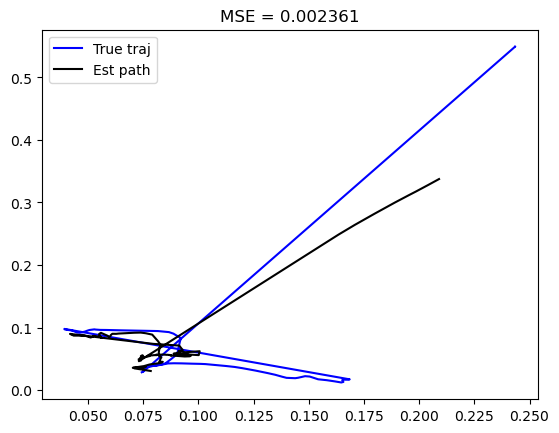

In [269]:
plot_some_paths(model, validation_dataloader, max_seq_time, criterion)